In [1]:
import glob
from PIL import Image#帮我们读取图像

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import torchvision
from torchvision import transforms

import os

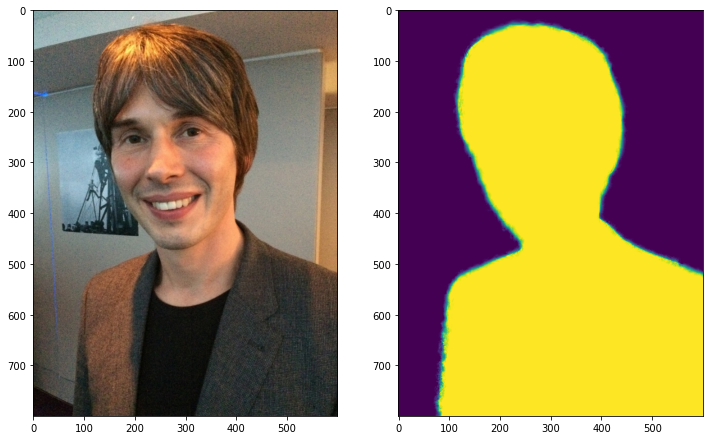

In [2]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
pil_img=Image.open(r'D:/数据集/HKdataset/testing/00001.png')
np_img=np.array(pil_img)
plt.imshow(np_img)
plt.subplot(1,2,2)
pil_img_2=Image.open(r'D:/数据集/HKdataset/testing/00001_matte.png')
np_img_2=np.array(pil_img_2)
plt.imshow(np_img_2)

In [3]:
np.unique(np_img_2)#看这个ndarray中包含哪些值

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [4]:
np_img_2[np_img_2>0]=1 #将所有不为0的像素值设成1方便进行二分类。

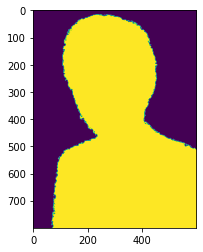

In [5]:
plt.imshow(np_img_2)

In [6]:
all_pics=glob.glob(r'D:\数据集\HKdataset\training\*.png')

In [7]:
images=[p for p in all_pics if 'matte' not in p]#使用中括号将原图和蒙版分开
anno=[p for p in all_pics if 'matte'  in p]

In [8]:
len(images),len(anno)

(1700, 1700)

In [9]:
index=np.random.permutation(len(images))

In [10]:
images=np.array(images)[index]
anno=np.array(anno)[index]

In [11]:
all_test_pics=glob.glob(r'D:\数据集\HKdataset\testing\*.png')

In [12]:
test_images=[p for p in all_test_pics if 'matte' not in p]
test_anno=[p for p in all_test_pics if 'matte' in p]

In [13]:
len(test_images),len(test_anno)

(300, 300)

In [19]:
pil_img_2=Image.open(r'D:/数据集/HKdataset/testing/00001_matte.png')
np_img_2=np.array(pil_img_2)

In [20]:
np_img_2.shape

(800, 600)

In [13]:
transform=transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])

In [14]:
class HK(data.Dataset):
    def __init__(self,imgs_path,anno_path):
        self.img_path=imgs_path
        self.anno_path=anno_path
    def __getitem__(self, index):
        img=self.img_path[index]
        anno=self.anno_path[index]
        
        pil_img=Image.open(img)
        img_tenser=transform(pil_img)

        anno_img=Image.open(anno)
        anno_tenser=transform(anno_img)
        
        anno_tenser=torch.squeeze(anno_tenser).type(torch.long)#现在的蒙版图像是256x256x1的，
                                    #用squeeze的方法将1的那个维度去掉,
                                    # 并转换为long类型输入模型因为必须是整数
        anno_tenser[anno_tenser>0]=1#将蒙版图像转换为二分类图像只有0和1
        return img_tenser,anno_tenser
    def __len__(self):
        return len(self.img_path)

In [15]:
train_ds=HK(images,anno)
test_ds=HK(test_images,test_anno)
train_dl=data.DataLoader(train_ds,batch_size=8,shuffle=True)
test_dl=data.DataLoader(test_ds,batch_size=8)

In [16]:
img_batch,anno_batch=next(iter(train_dl))

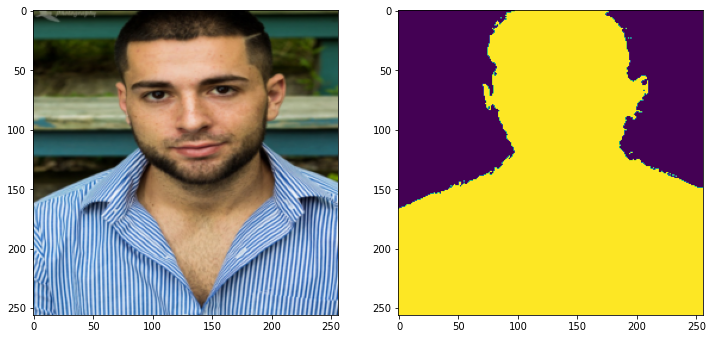

In [17]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(img_batch[0].permute(1,2,0).numpy())
plt.subplot(1,2,2)
plt.imshow(anno_batch[0].numpy())#本来就是二维的图像了所以不用转换维度次序

In [18]:
class Downsample(nn.Module):
    def __init__(self,in_channel,out_channel):
        super(Downsample,self).__init__()#继承父类的属性
        self.conv_relu=nn.Sequential(
            nn.Conv2d(in_channel,out_channel,kernel_size=3,padding=1),
                        #padding为1的话就是周围填充一圈，使卷积后图像的大小不变
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channel,out_channel,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
        )
        self.pool=nn.MaxPool2d(kernel_size=2)#定义一个2x2的最大池化
    def forward(self,x,is_pool=True):
                #设置一个判断，判断是否要做下采样，如输入时就不需要进行下采样默认为要做
        if is_pool:
            x=self.pool(x)
        x=self.conv_relu(x)
        return(x)


In [19]:
class Upsample(nn.Module):
    def __init__(self,channel):#也可一根据规律来写通道数，发现输出通道数一直是输入的一半，所以定义一个通道参数也可以
        super(Upsample,self).__init__()#继承父类的属性
        self.conv_relu=nn.Sequential(
            nn.Conv2d(2*channel,channel,kernel_size=3,padding=1),
                        #padding为1的话就是周围填充一圈，使卷积后图像的大小不变
            nn.ReLU(inplace=True),#设置这个就是直接对数据进行relu不保存中间数据，这样更快不占内存但不推荐
            nn.Conv2d(channel,channel,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
        )
        self.upconv_relu=nn.Sequential(
            nn.ConvTranspose2d(channel,channel//2,kernel_size=3,stride=2,padding=1,output_padding=1),
                            #pytorch内置的反卷积层，其参数与卷积的参数几乎一摸一样，但是有些不同
                            #反卷积需要跨度，没有跨度是实现不了图像的放大的，跨度起到放大的作用,为2表示放大两倍
                            #反卷积的padding指的是输入的起始位置，为2代表从第二个像素开始做反卷积
                            #必须要加padding否则图像会增大2（32->34）,不是原本大小了，就不能合并了
                            #outkput_padding反卷积之后在外面进行填充，类似于卷积的padding,边缘填充1来使输出图像与输入图像大小相同
            
            nn.ReLU(inplace=True)#池化不需要激活，反卷积需要激活
        )
    def forward(self,x):
        x=self.conv_relu(x)
        x=self.upconv_relu(x)
        return x

In [20]:
class Unet_model(nn.Module):
    def __init__(self):
        super(Unet_model,self).__init__()
        self.down1=Downsample(3,64)#再初始化时不需要写ispool参数，在前向传播的时候再写就行
        self.down2=Downsample(64,128)
        self.down3=Downsample(128,256)
        self.down4=Downsample(256,512)
        self.down5=Downsample(512,1024)

        self.up=nn.Sequential(
           nn.ConvTranspose2d(1024,512,kernel_size=3,stride=2,padding=1,output_padding=1),
           nn.ReLU()
        )

        self.up1=Upsample(512)
        self.up2=Upsample(256)
        self.up3=Upsample(128)

        self.conv_2=Downsample(128,64)#使用下采样加判断来不进行池化仅仅当作卷积来使用

        self.last=nn.Conv2d(64,2,kernel_size=1)#因为是二分类，所以输出维度是2
    def forward(self,x):

       x1=self.down1(x,is_pool=False) #第一层对输入图片只进行卷积不进行下采样
       x2=self.down2(x1)#使用不同的变量名称因为我们要将每一层的输出保留下来上采样时进行合并
       x3=self.down3(x2)
       x4=self.down4(x3)
       #print(x4.shape)
       x5=self.down5(x4)
       #print("上采样前的x5",x5.shape)
      
       x5=self.up(x5) #这是最底层，不需要保留输出了,以后的上采样也不需要合并了
       #print('上采样后的x5',x5.shape)
       x5=torch.cat([x4,x5],dim=1)#合并不是简单的相加，而是维度进行的合并，使用torch中的cat方法进行维度的合并
                        #在pytorch中，数据集的四个参数为为（batch，channel，w,h）所以是选择第一个维度进行合并
       x5=self.up1(x5)

       x5=torch.cat([x3,x5],dim=1)
       x5=self.up2(x5)

       x5=torch.cat([x2,x5],dim=1)
       x5=self.up3(x5)

       x5=torch.cat([x1,x5],dim=1)

       x5=self.conv_2(x5,is_pool=False)#最后也是进行两次卷积不进行池化

       x5=self.last(x5)#现在就是每一个像素点输出一个像素为2的向量

       return x5

In [21]:
model=Unet_model()

In [49]:
model

Unet_model(
  (down1): Downsample(
    (conv_relu): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down2): Downsample(
    (conv_relu): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down3): Downsample(
    (conv_relu): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inpl

In [152]:
loss_fn=nn.CrossEntropyLoss()#当多分类问题来处理（本质是二分类问题，输出的是一个长度为2的向量，是两个概率）
from torch.optim import lr_scheduler
optim=torch.optim.Adam(model.parameters(),lr=0.001)
exp_lr_scheduler=lr_scheduler.StepLR(optim,step_size=7,gamma=0.1)

In [25]:
def fit(epoch,model,trainloader,textloader):   #因为这个函数没有输入train_x和train_y所以直接用train_dl和text_dl来算正确率
    correct=0                            #通过记录预测正确的个数和样本总数之间的比值来看正确率
    total=0                              #总样本的个数
    running_loss=0
    model.train()      #使用dropout层和BN层时一定要加这一句表明模型正处于训练状态下  
    for x,y in trainloader:  
        x,y=x.to('cuda'),y.to('cuda') #如果要使用GPU进行加速计算就打开屏蔽 
        y_pred=model(x)
        loss=loss_fn(y_pred,y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        with torch.no_grad():                  #每一个y值进行一次计算，这是对训练数据
            y_pred=torch.argmax(y_pred,dim=1)
            correct+=(y_pred==y).sum().item()  #每一次正确的个数加到correct里
            total+=y.size(0)                   #每一批样本的个数
            running_loss+=loss.item()          #每一批样本的loss
        
    exp_lr_scheduler.step() #如果定义了学习速率衰减可以打开这个屏蔽
    
    epoch_acc=correct/(total*256*256)                #正确率为正确个数除以样本个数
    epoch_loss=running_loss/len(trainloader.dataset)  #平均loss为一个批次的总loss除以训练的长度
    
    
    text_correct=0                          #这是对测试数据 ,对于测试数据不用反向传播不用优化
    text_total=0                              
    text_running_loss=0
    model.eval()      #告诉模型现在是预测模式，dropout层不需要发挥作用  
    with torch.no_grad():                  
            for x,y in textloader: 
                x,y=x.to('cuda'),y.to('cuda') #如果要使用GPU进行加速计算就打开屏蔽 
                y_pred=model(x)
                loss=loss_fn(y_pred,y)
                y_pred=torch.argmax(y_pred,dim=1)
                text_correct+=(y_pred==y).sum().item() 
                text_total+=y.size(0)                   
                text_running_loss+=loss.item()
    
    epoch_text_acc=text_correct/(text_total*256*256)               
    epoch_text_loss=running_loss/len(textloader.dataset)  
    
    print('epoch: ',epoch,'loss: ',round(epoch_loss,3),
                            'accuracy: ',round(epoch_acc,3),
                            'text_loss: ',round(epoch_text_loss,3),
                            'text_accuracy: ',round(epoch_text_acc,3))
    return epoch_loss,epoch_acc,epoch_text_loss,epoch_text_acc  
                                                #这样就会将每个epoch上的这些平均正确率和平均损失返回

In [156]:
def fit(epoch,model,trainloader,textloader):   #因为这个函数没有输入train_x和train_y所以直接用train_dl和text_dl来算正确率
    correct=0                            #通过记录预测正确的个数和样本总数之间的比值来看正确率
    total=0                              #总样本的个数
    running_loss=0
    epoch_IOU=[]
    model.train()      #使用dropout层和BN层时一定要加这一句表明模型正处于训练状态下  
    for x,y in trainloader:  
        x,y=x.to('cuda'),y.to('cuda') #如果要使用GPU进行加速计算就打开屏蔽 
        y_pred=model(x)
        loss=loss_fn(y_pred,y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        with torch.no_grad():                  #每一个y值进行一次计算，这是对训练数据
            y_pred=torch.argmax(y_pred,dim=1)
            correct+=(y_pred==y).sum().item()  #每一次正确的个数加到correct里
            total+=y.size(0)                   #每一批样本的个数
            running_loss+=loss.item()          #每一批样本的loss

            intersection=torch.logical_and(y,y_pred)#使用torch内置的与运算计算预测值与实际值之间的交集
            union=torch.logical_or(y,y_pred)#使用torch内置的交运算计算预测值与实际值之间的并集
            batch_IOU=torch.true_divide(torch.sum(intersection.cpu()),torch.sum(union.cpu()))
                                    #因为这些都是tensor类型，所以使用torch的求和 和相除方法
                                    #因为之后要求一个epoch中所有IOU的平均值，所以将其放在cpu上这样才能转换成numpy再求平均值
            epoch_IOU.append(batch_IOU)


        
    exp_lr_scheduler.step() #如果定义了学习速率衰减可以打开这个屏蔽
    
    epoch_acc=correct/(total*256*256)                #正确率为正确个数除以样本个数
    epoch_loss=running_loss/len(trainloader.dataset)  #平均loss为一个批次的总loss除以训练的长度
    
    
    text_correct=0                          #这是对测试数据 ,对于测试数据不用反向传播不用优化
    text_total=0                              
    text_running_loss=0
    test_epoch_IOU=[]
    model.eval()      #告诉模型现在是预测模式，dropout层不需要发挥作用  
    with torch.no_grad():                  
            for x,y in textloader: 
                x,y=x.to('cuda'),y.to('cuda') #如果要使用GPU进行加速计算就打开屏蔽 
                y_pred=model(x)
                loss=loss_fn(y_pred,y)
                y_pred=torch.argmax(y_pred,dim=1)
                text_correct+=(y_pred==y).sum().item() 
                text_total+=y.size(0)                   
                text_running_loss+=loss.item()
                intersection=torch.logical_and(y,y_pred)#使用torch内置的与运算计算预测值与实际值之间的交集
                union=torch.logical_or(y,y_pred)#使用torch内置的交运算计算预测值与实际值之间的并集
                batch_IOU=torch.true_divide(torch.sum(intersection.cpu()),torch.sum(union.cpu()))
                test_epoch_IOU.append(batch_IOU)
    
    epoch_text_acc=text_correct/(text_total*256*256)               
    epoch_text_loss=running_loss/len(textloader.dataset)  
    
    print('epoch: ',epoch,'loss: ',round(epoch_loss,3),
                            'accuracy: ',round(epoch_acc,3),
                            'train_IOU:',round(np.mean(epoch_IOU),3),#在每一个批次结果相同时可以这么写
                            'text_loss: ',round(epoch_text_loss,3),
                            'text_accuracy: ',round(epoch_text_acc,3),
                            'test_IOU:',round(np.mean(test_epoch_IOU),3))
                            
    return epoch_loss,epoch_acc,epoch_IOU,epoch_text_loss,epoch_text_acc,test_epoch_IOU  
                                                #这样就会将每个epoch上的这些平均正确率和平均损失返回

In [157]:
epoch=20
model.to('cuda')

Unet_model(
  (down1): Downsample(
    (conv_relu): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down2): Downsample(
    (conv_relu): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down3): Downsample(
    (conv_relu): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inpl

In [158]:
train_loss=[] #创建几个空的列表来存放数据,方便绘图，看看模型怎么样
train_acc=[]
text_loss=[]
text_acc=[]

In [28]:
import copy
best_acc=0

for epoch in range(epoch):
    epoch_loss,epoch_acc,epoch_text_loss,epoch_text_acc =fit(epoch,model,train_dl,test_dl)
    
    if epoch_text_acc > best_acc:
        best_model_wts=copy.deepcopy(model.state_dict()) #达到目前最高的正确率时复制此时的模型权重
        best_acc=epoch_text_acc
    
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    text_loss.append(epoch_text_loss)
    text_acc.append(epoch_text_acc)
    
model.load_state_dict(best_model_wts)#在整个模型训练完成后给模型最优情况的权重值，在使用这个模型之前要先设置成																					model.eval()模式

C:\ProgramData\Anaconda3\envs\text\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch:  0 loss:  0.075 accuracy:  45257.569 text_loss:  0.425 text_accuracy:  49393.057
epoch:  1 loss:  0.058 accuracy:  51814.494 text_loss:  0.331 text_accuracy:  54169.297
epoch:  2 loss:  0.046 accuracy:  55382.682 text_loss:  0.259 text_accuracy:  56311.897
epoch:  3 loss:  0.042 accuracy:  56283.735 text_loss:  0.239 text_accuracy:  55967.873
epoch:  4 loss:  0.039 accuracy:  57035.884 text_loss:  0.22 text_accuracy:  56913.797
epoch:  5 loss:  0.037 accuracy:  57534.036 text_loss:  0.208 text_accuracy:  57116.107
epoch:  6 loss:  0.034 accuracy:  58223.85 text_loss:  0.192 text_accuracy:  58272.35
epoch:  7 loss:  0.029 accuracy:  59320.046 text_loss:  0.164 text_accuracy:  58944.517
epoch:  8 loss:  0.028 accuracy:  59596.748 text_loss:  0.157 text_accuracy:  59224.483
epoch:  9 loss:  0.027 accuracy:  59813.836 text_loss:  0.152 text_accuracy:  59388.607
epoch:  10 loss:  0.026 accuracy:  59965.427 text_loss:  0.148 text_accuracy:  59413.883
epoch:  11 loss:  0.025 accuracy: 

<All keys matched successfully>

In [ ]:
PATH = 'unet_model.pth'
torch.save(model.state_dict(), PATH)

In [23]:
new_model=Unet_model()
new_model.load_state_dict(torch.load('unet_model.pth'))

<All keys matched successfully>

In [38]:
num=3
img_batch,mask_bath=next(iter(test_dl))

In [40]:
pred_batch=new_model(img_batch)

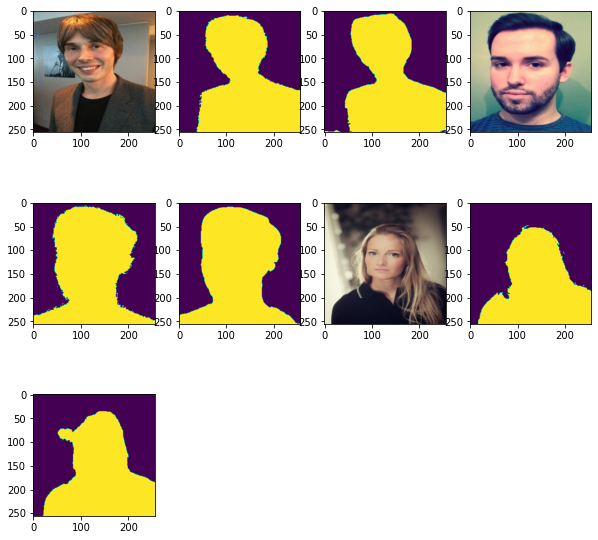

In [53]:
plt.figure(figsize=(10,10))
for i in range(num):
    plt.subplot(3,4,i*num+1)#绘制原图片
    plt.imshow(img_batch[i].permute(1,2,0).cpu().numpy())#原来是在显卡上运行的，现在将它放在cpu上

    plt.subplot(3,4,i*num+2)#绘制实际蒙版
    plt.imshow(mask_bath[i].cpu().numpy())#mask没有维度所以只将其放在cpu上就可以了

    plt.subplot(3,4,i*num+3)#绘制预测蒙版
    plt.imshow(torch.argmax(a[i].permute(1,2,0),axis=-1).detach().numpy())
                #因为是二分类切将分类的维度信息用permute放到了最后所以使用argmax获取最后一个维度的分类结果
                #用dim=-1或者axis=-1是一样的

## 预测应用

In [23]:
model.load_state_dict(torch.load('linknet_model.pth'))

<All keys matched successfully>

In [43]:
#path='D:/python/picture/tao.jpg'
#path='D:/python/picture/test3.jpg'
path='D:/python/singer/xuezhiqian/xuezhiqian3.jpg'

In [44]:
pil_img=Image.open(path)

In [45]:
img_tensor=transform(pil_img)

In [46]:
img_tensor_batch=torch.unsqueeze(img_tensor,0)
#图片输入模型是一个batch一个batch输入进模型的，相当于是4维输入进模型，
# 所以我们使用torch.unsqueeze()方法添加一个1维度在这张图片的开头
#squeeze是去掉一个内容为 1 的维度，unsqueeze是添加一个内容为 1 的维度

In [47]:
img_tensor_batch.shape

torch.Size([1, 3, 256, 256])

In [48]:
pred=model(img_tensor_batch)

In [49]:
pred=torch.squeeze(pred,0)

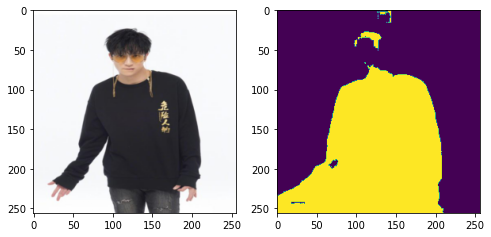

In [50]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(transform(pil_img).permute(1,2,0).numpy())
plt.subplot(1,2,2)
plt.imshow(torch.argmax(pred.permute(1,2,0),dim=-1).detach().numpy())

In [82]:
a=pred[0]

In [83]:
a.shape

torch.Size([2, 256, 256])

In [90]:
b=torch.squeeze(pred,0)

In [91]:
a.shape

torch.Size([2, 256, 256])

In [92]:
b.shape

torch.Size([2, 256, 256])

In [93]:
a==b

tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]])

In [97]:
pred.shape

torch.Size([1, 2, 256, 256])

In [99]:
torch.squeeze(pred,0).shape

torch.Size([2, 256, 256])

# Linknet网络

In [16]:
class conv_block(nn.Module):
    def __init__(self,in_channel,out_channel,k_size=3,stride=1,pad=1):#因为在所有使用卷积时会使用到不同大小的卷积核（大部分为3），
                                                #有些卷积层还要进行缩放所以再定义一个stride参数（大部分为1）
                                                #使3*3的卷积后的图像大小不变，所以加一个pad参数，默认为1
        super().__init__()
        self.conv_bn_relu=nn.Sequential(
            nn.Conv2d(in_channel,out_channel,kernel_size=k_size,stride=stride,padding=pad),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True)
        )
    def forward(self,x):
        x=self.conv_bn_relu(x)
        return x

In [17]:
class deconv_block(nn.Module):
    def __init__(self,in_channel,out_channel,k_size=3,stride=2,pad=1,output_padding=1):
                        #添加一个参数output_padding默认为1使图像大小和输入大小相同
                        #stride为2的话就是将图像放大一倍
        super().__init__()
        self.deconv=nn.ConvTranspose2d(in_channel,out_channel,
                                        kernel_size=k_size,
                                        stride=stride,
                                        padding=pad,
                                        output_padding=output_padding)
        self.bn=nn.BatchNorm2d(out_channel)
    def forward(self,x,is_act=True):#给一个参数来判断是否需要激活,默认需要激活
        x=self.deconv(x)
        if is_act:
            x=torch.relu(self.bn(x))
        return x

In [18]:
class Encode_block(nn.Module):
    def __init__(self,in_channel,out_channel):
        super().__init__()
        self.con1=conv_block(in_channel,out_channel,stride=2)#第一个卷积层对图像进行缩放
        self.con2=conv_block(out_channel,out_channel)#之后的三层都是out_channel

        self.con3=conv_block(out_channel,out_channel)
        self.con4=conv_block(out_channel,out_channel)

        self.res=conv_block(in_channel,out_channel,stride=2)#残差模块也需要缩放再进相加
    def forward(self,x):
        out1=self.con1(x)
        out1=self.con2(out1)
        short_cut=self.res(x)
        
        out2=self.con3(short_cut+out1)
        out2=self.con4(out2)

        return out1+out2#最后哦返回俩个输出相加

In [19]:
class Decode_block(nn.Module):
    def __init__(self,in_channel,out_channel):
        super().__init__()
        self.con1=conv_block(in_channel,in_channel//4,k_size=1,pad=0)
                            #使卷积核的大小为1x1,此时padding就得去掉了否则就相当于把图像的长宽都扩大了2
        self.decon=deconv_block(in_channel//4,in_channel//4)#反卷积模块默认放大到2倍，所以不用去设置
        self.con2=conv_block(in_channel//4,out_channel,k_size=1,pad=0)#第三个卷积层的卷积核也是1x1的
        
    def forward(self,x):
        x=self.con1(x)
        x=self.decon(x)
        x=self.con2(x)
        return x

In [20]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_conv=conv_block(3,64,k_size=7,stride=2,pad=3)#这是输入部分的卷积
        self.input_maxpool=nn.MaxPool2d(kernel_size=(2,2))#对原图进行缩放

        self.encode1=Encode_block(64,64)
        self.encode2=Encode_block(64,128)
        self.encode3=Encode_block(128,256)
        self.encode4=Encode_block(256,512)

        self.decode4=Decode_block(512,256)#这样decode4和encode3的结果是一样的，可以相加
        self.decode3=Decode_block(256,128)
        self.decode2=Decode_block(128,64)
        self.decode1=Decode_block(64,64)

        self.deconv_out1=deconv_block(64,32)#反卷积模块默认放大2倍
        self.conv_out=conv_block(32,32)
        self.deconv_out2=deconv_block(32,2,k_size=2,pad=0,output_padding=0)#因为我们是二分类问题，所以最后输出两个通道
                                                            #因为反卷积核的大小变成了2 所以为了使图像不变，将padding和output_padding都改为0（会变成两倍但像素不进行加减）

    def forward(self,x):
        x=self.input_conv(x)
        x=self.input_maxpool(x)

        e1=self.encode1(x)
        e2=self.encode2(e1)
        e3=self.encode3(e2)
        e4=self.encode4(e3)#使用不同参数的原因是要将他们保留下来以便之后的合并

        d4=self.decode4(e4)+e3
        d3=self.decode3(d4)+e2
        d2=self.decode2(d3)+e1
        d1=self.decode1(d2)

        f1=self.deconv_out1(d1)
        f2=self.conv_out(f1)
        f3=self.deconv_out2(f2,is_act=False)#最后一层就直接输出了，不需要再进行BN以及激活了
        
        return  f3

In [21]:
model=Net()

In [132]:
model

Net(
  (input_conv): conv_block(
    (conv_bn_relu): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (input_maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (encode1): Encode_block(
    (con1): conv_block(
      (conv_bn_relu): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (con2): conv_block(
      (conv_bn_relu): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (con3): conv_block(
      (conv_bn_relu):

In [133]:
loss_fn=nn.CrossEntropyLoss()
optim=torch.optim.Adam(model.parameters(),lr=0.001)
model.to('cuda')

Net(
  (input_conv): conv_block(
    (conv_bn_relu): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (input_maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (encode1): Encode_block(
    (con1): conv_block(
      (conv_bn_relu): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (con2): conv_block(
      (conv_bn_relu): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (con3): conv_block(
      (conv_bn_relu):

In [153]:
def fit(epoch,model,trainloader,textloader):   #因为这个函数没有输入train_x和train_y所以直接用train_dl和text_dl来算正确率
    correct=0                            #通过记录预测正确的个数和样本总数之间的比值来看正确率
    total=0                              #总样本的个数
    running_loss=0
    epoch_IOU=[]
    model.train()      #使用dropout层和BN层时一定要加这一句表明模型正处于训练状态下  
    for x,y in trainloader:  
        x,y=x.to('cuda'),y.to('cuda') #如果要使用GPU进行加速计算就打开屏蔽 
        y_pred=model(x)
        loss=loss_fn(y_pred,y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        with torch.no_grad():                  #每一个y值进行一次计算，这是对训练数据
            y_pred=torch.argmax(y_pred,dim=1)
            correct+=(y_pred==y).sum().item()  #每一次正确的个数加到correct里
            total+=y.size(0)                   #每一批样本的个数
            running_loss+=loss.item()          #每一批样本的loss

            intersection=torch.logical_and(y,y_pred)#使用torch内置的与运算计算预测值与实际值之间的交集
            union=torch.logical_or(y,y_pred)#使用torch内置的交运算计算预测值与实际值之间的并集
            batch_IOU=torch.true_divide(torch.sum(intersection.cpu()),torch.sum(union.cpu()))
                                    #因为这些都是tensor类型，所以使用torch的求和 和相除方法
                                    #因为之后要求一个epoch中所有IOU的平均值，所以将其放在cpu上这样才能转换成numpy再求平均值
            epoch_IOU.append(batch_IOU)


        
    exp_lr_scheduler.step() #如果定义了学习速率衰减可以打开这个屏蔽
    
    epoch_acc=correct/(total*256*256)                #正确率为正确个数除以样本个数
    epoch_loss=running_loss/len(trainloader.dataset)  #平均loss为一个批次的总loss除以训练的长度
    
    
    text_correct=0                          #这是对测试数据 ,对于测试数据不用反向传播不用优化
    text_total=0                              
    text_running_loss=0
    test_epoch_IOU=[]
    model.eval()      #告诉模型现在是预测模式，dropout层不需要发挥作用  
    with torch.no_grad():                  
            for x,y in textloader: 
                x,y=x.to('cuda'),y.to('cuda') #如果要使用GPU进行加速计算就打开屏蔽 
                y_pred=model(x)
                loss=loss_fn(y_pred,y)
                y_pred=torch.argmax(y_pred,dim=1)
                text_correct+=(y_pred==y).sum().item() 
                text_total+=y.size(0)                   
                text_running_loss+=loss.item()
                intersection=torch.logical_and(y,y_pred)#使用torch内置的与运算计算预测值与实际值之间的交集
                union=torch.logical_or(y,y_pred)#使用torch内置的交运算计算预测值与实际值之间的并集
                batch_IOU=torch.true_divide(torch.sum(intersection.cpu()),torch.sum(union.cpu()))
                test_epoch_IOU.append(batch_IOU)
    
    epoch_text_acc=text_correct/(text_total*256*256)               
    epoch_text_loss=running_loss/len(textloader.dataset)  
    
    print('epoch: ',epoch,'loss: ',round(epoch_loss,3),
                            'accuracy: ',round(epoch_acc,3),
                            'train_IOU:',round(np.mean(epoch_IOU),3),#在每一个批次结果相同时可以这么写
                            'text_loss: ',round(epoch_text_loss,3),
                            'text_accuracy: ',round(epoch_text_acc,3),
                            'test_IOU:',round(np.mean(test_epoch_IOU),3))
                            
    return epoch_loss,epoch_acc,epoch_IOU,epoch_text_loss,epoch_text_acc,test_epoch_IOU  
                                                #这样就会将每个epoch上的这些平均正确率和平均损失返回

In [161]:
train_loss=[] #创建几个空的列表来存放数据,方便绘图，看看模型怎么样
train_acc=[]
test_loss=[]
test_acc=[]
train_iou=[]
test_iou=[]
epochs=50

In [162]:
for epoch in range(epochs):
    epoch_loss,epoch_acc,epoch_IOU,epoch_test_loss,epoch_test_acc ,test_epoch_IOU=fit(epoch,model,train_dl,test_dl)
    
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    train_iou.append(epoch_IOU)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)
    test_iou.append(test_epoch_IOU)

epoch:  0 loss:  0.036 accuracy:  0.881 train_IOU: 0.81 text_loss:  0.205 text_accuracy:  0.89 test_IOU: 0.827
epoch:  1 loss:  0.034 accuracy:  0.892 train_IOU: 0.826 text_loss:  0.19 text_accuracy:  0.899 test_IOU: 0.836
epoch:  2 loss:  0.03 accuracy:  0.904 train_IOU: 0.843 text_loss:  0.17 text_accuracy:  0.896 test_IOU: 0.835
epoch:  3 loss:  0.026 accuracy:  0.917 train_IOU: 0.863 text_loss:  0.149 text_accuracy:  0.918 test_IOU: 0.863
epoch:  4 loss:  0.021 accuracy:  0.934 train_IOU: 0.889 text_loss:  0.119 text_accuracy:  0.927 test_IOU: 0.879
epoch:  5 loss:  0.02 accuracy:  0.939 train_IOU: 0.896 text_loss:  0.112 text_accuracy:  0.93 test_IOU: 0.883
epoch:  6 loss:  0.019 accuracy:  0.942 train_IOU: 0.901 text_loss:  0.107 text_accuracy:  0.93 test_IOU: 0.884
epoch:  7 loss:  0.018 accuracy:  0.944 train_IOU: 0.905 text_loss:  0.102 text_accuracy:  0.931 test_IOU: 0.884
epoch:  8 loss:  0.017 accuracy:  0.947 train_IOU: 0.909 text_loss:  0.098 text_accuracy:  0.932 test_IO

KeyboardInterrupt: 

In [163]:
PATH = 'unet_model.pth'
torch.save(model.state_dict(), PATH)